<a href="https://colab.research.google.com/github/marthery/2022/blob/main/Loading_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data overview

Given a vector of features representing the decay signature of a collision event, predict whether this signal was a **Higgs Boston (s, 1) or background (b, -1)**. 

We are provided with a train dataset and a test one. We will create a validation test as well. 

Here are a summary of the different features in the train dataset:

*The file starts with the ID column, then the label column (the y you have to predict), and finally 30 feature columns.*

###Some details to get started:

all variables are floating point, except PRI_jet_num which is integer
variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.


## Creating train/validation/test arrays

In [80]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import datetime
import csv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
def load_data(path_dataset):
    """Load data"""
    X = np.genfromtxt(
        path_dataset, delimiter=",", skip_header=1)
    y = np.genfromtxt(
        path_dataset, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x_indices = X[:,0]

    #Take x and add columns of ones 
    x = X[:, 2:]
    num_samples = len(y)
    tx = np.c_[np.ones(num_samples), x]

    #Convert y to binary values (0 and 1) QUESTION: should we do -1 and 1 instead? 
    binary_y = np.zeros([len(y)])
    for i in range(len(y)):
      if y[i] == 's':
        binary_y[i]=1
    return tx, binary_y, x_indices

#TO COMPLETE LATER
def train_validation_dataset(x, y, percent):
    """Generate the train/validation x and y by shuffling the dataset. 
    Percent represents the percentage of training set that is going to be used for creating the validation set"""
    data_size = len(y)

    shuffle_indices = np.random.permutation(np.arange(data_size))
    shuffled_y = y[shuffle_indices]
    shuffled_x = x[shuffle_indices]

    start_index = 0
    end_index = data_size * percent
    if start_index != end_index:
      yield shuffled_y[start_index:end_index], shuffled_x[start_index:end_index]

In [98]:
def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x)
    x = x - mean_x
    std_x = np.std(x)
    x = x / std_x
    return x, mean_x, std_x

In [82]:
#Create training/testing set
#Preprocessed data : standardization, missing values, a lot of missing values with -999
tx, y, x_indices = load_data('train.csv')

In [99]:
tx, mean_tx, std_tx = standardize(tx)

## Least Squares GD

In [97]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE."""
    e = np.square(y - np.dot(tx,w))
    return np.sum(e)/len(y)

In [92]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w. 
    Returns an numpy array of shape (31, ) (same shape as w), containing the gradient of the loss at w."""
    e = y - np.dot(tx,w)
    return -np.dot(np.transpose(tx), e)/len(y)

In [93]:
def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm using MSE cost function."""
    w = initial_w
    losses = []
    for n_iter in range(max_iters):
      loss = compute_loss(y, tx, w)
      gradient = compute_gradient(y, tx, w)
      w = w - np.dot(gradient, gamma)
      losses.append(loss)
    return w, loss, losses

In [100]:
# Define the parameters of the algorithm.
max_iters = 1000
gamma = 0.01
initial_w = np.ones([31])
w, loss, losses = least_squares_GD (y, tx, initial_w, max_iters, gamma)

Text(0, 0.5, 'log loss')

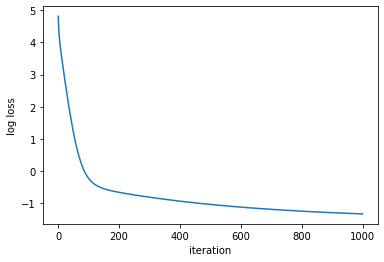

In [102]:
plt.plot(np.log(losses))
plt.xlabel('iteration')
plt.ylabel('log loss')

Text(0, 0.5, 'loss')

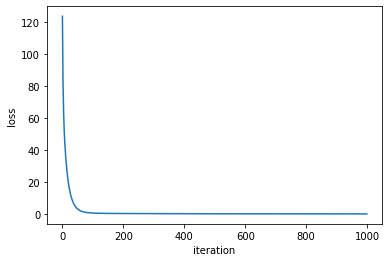

In [101]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('loss')

## Least Squares SGD

In [103]:
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

In [110]:
def least_squares_SGD(y, tx, initial_w, max_iters, gamma):
    batch_size = 100
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
      for y_batch, tx_batch in batch_iter(y,tx, batch_size): 
        loss = compute_loss(y_batch, tx_batch, w)
        gradient = compute_gradient(y_batch, tx_batch, w)
        w = w - np.dot(gradient, gamma)
        losses.append(loss)
    return w, loss, losses

In [111]:
#Must use mini batch size, I don't understand why
w_sgd, loss_sgd, losses_sgd = least_squares_SGD(y, tx, initial_w, max_iters, gamma)

Text(0, 0.5, 'log loss')

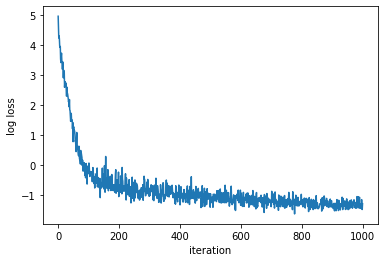

In [115]:
plt.plot(np.log(losses_sgd))
plt.xlabel('iteration')
plt.ylabel('log loss')

Text(0, 0.5, 'loss')

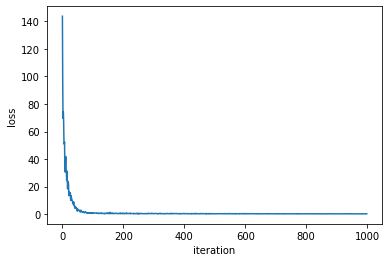

In [116]:
plt.plot(losses_sgd)
plt.xlabel('iteration')
plt.ylabel('loss')